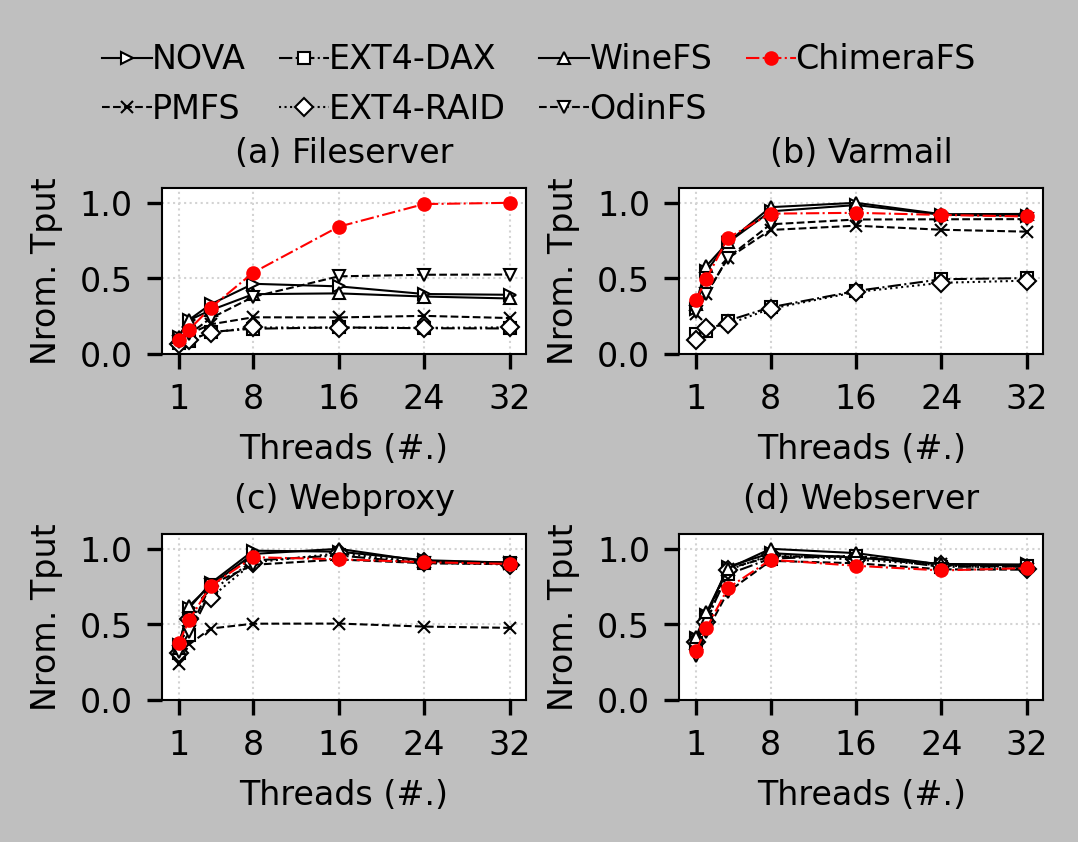

In [2]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd

STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54

# matplotlib style settings
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None


with open("./performance-comparison-table-store", "r") as f:
    df = pd.read_csv(f, index_col=None, engine='python', sep=' ')
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(6)))

colors = ['white', 'white', 'white', 'white', 'white', 'white', 'black']
marks = [">", "x", "s", "D", "^", "v", "o"]
line_patterns = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"]
fbs = ["fileserver.f", "varmail.f", "webproxy.f", "webserver.f"]
titles = ["(a) Fileserver", "(b) Varmail", "(c) Webproxy", "(d) Webserver"]
fss = ["nova", "pmfs", "ext4-dax", "ext4-raid", "winefs", "odinfs-12", "parfs-12"]
num_jobs = [1, 2, 4, 8, 16, 24, 32]
x = list(num_jobs) 

mapping = {
    "nova":"NOVA",
    "pmfs":"PMFS",
    "ext4-dax":"EXT4-DAX",
    "ext4-raid":"EXT4-RAID",
    "winefs":"WineFS",
    "odinfs-12":"OdinFS",
    "parfs-12":"ChimeraFS",
}
mapped_fss = [mapping.get(item, item) for item in fss]

max_iops_per_bench = df.groupby('fbench')['iops'].max().to_dict()
df['normalized_iops'] = df.apply(lambda row: row['iops'] / max_iops_per_bench[row['fbench']], axis=1)

lines = []
for i in range(4):
    plt.subplot(2, 2, i + 1)
    fb = fbs[i]
    for idx, fs in enumerate(fss):
        y = df[(df['fs'] == fs) & (df['fbench'] == fb)]['normalized_iops'].iloc[:len(num_jobs)]
        color="red" if fs == "parfs-12" else "black"
        markerfacecolor="red" if fs == "parfs-12" else colors[idx]
        markeregdecolor="red" if fs == "parfs-12" else "black"
        p, = plt.plot(x, y, color=color, markerfacecolor=markerfacecolor, linewidth=0.5,label=fs, marker=marks[idx], markeredgecolor=markeregdecolor, markersize=3, markeredgewidth=0.5, linestyle=line_patterns[idx])
        lines.append(p)

    ytick = [0, 0.5, 1]
    plt.yticks(ytick, fontsize=8)
    plt.ylabel('Nrom. Tput', fontsize=8)


    plt.ylim(0, 1.1)
    plt.xlabel("Threads (#.)", fontsize=8) 
    plt.title(titles[i], fontsize=8)

    # plt.tick_params(axis='y', pad=0, width=1)
    # plt.tick_params(axis='x', pad=2, width=2)

    ax = plt.gca()
    # ax.tick_params(axis='y', which='major', length=1, width = 0.5, direction='out', right=False, left=True)
    # ax.tick_params(axis='x', which='major', length=1.5, width = 0.5, direction='out', top=False, bottom=True)
    # ax.yaxis.set_tick_params(which='major', size=2)
    # plt.tick_params(left=True, bottom=True, right=False, top=False, which='major', width=0.5, length=3)

    plt.xticks([1, 8, 16, 24, 32], labels=[1, 8, 16, 24, 32], fontsize=8)
    ax = plt.gca()
    lw = 0.5
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)

fig.legend(lines, mapped_fss, loc='center', bbox_to_anchor=(0.5, 1.05), ncol=4, columnspacing=1, handletextpad=0, handlelength=1.5, frameon=False, fontsize=8)

# plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.6, wspace=0.1)
plt.tight_layout(pad=0.4)
plt.savefig("./Filebench.pdf", bbox_inches='tight', pad_inches=0)

In [4]:
import pandas as pd

# Load the dataset
column_names = ["fs", "fbench", "threads", "iops", "create", "delete", "close", "read", "write", "IO"]
df = pd.read_csv("performance-comparison-table-store", sep=r"\s+", names=column_names, header=0)

# Convert numeric columns
numeric_cols = ["threads", "iops", "create", "delete", "close", "read", "write", "IO"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Filter for fileserver workload
fs_fileserver = df[df['fbench'] == 'fileserver.f']

# Pivot to have fs types as columns
pivot = fs_fileserver.pivot(index='threads', columns='fs', values='iops')

# Ensure parfs-12 exists
if 'parfs-12' not in pivot.columns:
    raise ValueError("parfs-12 data not found for fileserver.f")

# Compute ratios: parfs-12 iops divided by each other filesystem's iops
other_fs = pivot.columns.drop('parfs-12')
ratios = pd.DataFrame(
    {fs: pivot['parfs-12'] / pivot[fs] for fs in other_fs},
    index=pivot.index
)

# Find highest and lowest ratio per thread count
results = []
for threads, row in ratios.iterrows():
    highest_fs = row.idxmax()
    highest_ratio = row.max()
    lowest_fs = row.idxmin()
    lowest_ratio = row.min()
    results.append({
        'threads': threads,
        'highest_fs': highest_fs,
        'highest_ratio': highest_ratio,
        'lowest_fs': lowest_fs,
        'lowest_ratio': lowest_ratio
    })

# Display results
results_df = pd.DataFrame(results).sort_values('threads')
print(results_df.to_string(index=False))


 threads highest_fs  highest_ratio lowest_fs  lowest_ratio
       1  ext4-raid       1.393731      nova      0.786827
       2   ext4-dax       1.876185      nova      0.715878
       4  ext4-raid       2.144536      nova      0.930470
       8   ext4-dax       3.208935      nova      1.159932
      16  ext4-raid       4.810047 odinfs-12      1.637925
      28   ext4-dax       5.785761 odinfs-12      1.890296
      32   ext4-dax       5.886228 odinfs-12      1.900428
